# Introduction

In this noteoook we take all the cleaned data - pollutants, historical weather and weather forecast - and examine which of the weather data features are likely to be useful in prediction.

We do this by examining heatmaps of correlation between a) weather forecast and pollutants, and b) historical weather and pollutants.

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

# Load data

In [2]:
ts_pollutants_path = 'data/Air Quality/Historical to 2022-08-29/Processed pollutants data.gz'
ts_pollutants_df = pd.read_csv(ts_pollutants_path, parse_dates = ['Datetime'])

In [3]:
ts_pollutants_df

,Polluant,Datetime,Concentration
0,NO2,2013-01-02 00:00:00,7.666667
1,NO2,2013-01-02 01:00:00,5.916667
2,NO2,2013-01-02 02:00:00,5.908333
3,NO2,2013-01-02 03:00:00,11.308333
4,NO2,2013-01-02 04:00:00,15.191667
...,...,...,...
423235,SO2,2022-08-29 19:00:00,0.675000
423236,SO2,2022-08-29 20:00:00,0.600000
423237,SO2,2022-08-29 21:00:00,0.525000
423238,SO2,2022-08-29 22:00:00,0.633330


In [4]:
pollutants_df = ts_pollutants_df.pivot_table(
    index = 'Datetime',
    columns = 'Polluant',
    values = 'Concentration'
)
pollutants_df.columns.name = None

In [5]:
weather_forecast_data = (
    pd.read_csv('data/Weather forecast/Historical to 2022-08-29/Cleaned weather forecast data.gz')
    .pivot_table(
        index = ['location', 'Datetime']
    )
)

# Convert Datetime index from string to datetime.
weather_forecast_data.index = weather_forecast_data.index.set_levels(
    weather_forecast_data.index.levels[1].astype('datetime64[ns]'), level=1
)

In [6]:
weather_forecast_data

DewPointC  cloudcover  humidity  precipMM  \
location    Datetime                                                         
Marseille   2013-01-02 00:00:00          5          18        85       0.0   
            2013-01-02 01:00:00          5          22        86       0.0   
            2013-01-02 02:00:00          5          26        86       0.0   
            2013-01-02 03:00:00          5          30        87       0.0   
            2013-01-02 04:00:00          4          24        86       0.0   
...                                    ...         ...       ...       ...   
Montpellier 2022-08-29 19:00:00         22           6        76       0.0   
            2022-08-29 20:00:00         21           8        79       0.0   
            2022-08-29 21:00:00         21           9        82       0.0   
            2022-08-29 22:00:00         21           8        82       0.0   
            2022-08-29 23:00:00         20           8        83       0.0   

                                 pressure  tempC  visibility  winddirDegree  \
location    Datetime                                                          
Marseille   2013-01-02 00:00:00      1017      8          10            314   
            2013-01-02 01:00:00      1017      7          10            317   
            2013-01-02 02:00:00      1017      7          10            320   
            2013-01-02 03:00:00      1017      7          10            323   
            2013-01-02 04:00:00      1017      6          10            322   
...                                   ...    ...         ...            ...   
Montpellier 2022-08-29 19:00:00      1014     26          10            117   
            2022-08-29 20:00:00      1014     25          10            110   
            2022-08-29 21:00:00      1014     24          10            103   
            2022-08-29 22:00:00      1014     24          10             97   
            2022-08-29 23:00:00      1014     23          10             90   

                                 windspeedKmph  
location    Datetime                            
Marseille   2013-01-02 00:00:00             20  
            2013-01-02 01:00:00             23  
            2013-01-02 02:00:00             27  
            2013-01-02 03:00:00             30  
            2013-01-02 04:00:00             28  
...                                        ...  
Montpellier 2022-08-29 19:00:00             16  
            2022-08-29 20:00:00             14  
            2022-08-29 21:00:00             12  
            2022-08-29 22:00:00             13  
            2022-08-29 23:00:00             14  

[169296 rows x 9 columns]

In [7]:
actual_weather_data = (
    pd.read_csv('data/Historical weather/Historical to 2022-08-29/Cleaned historical weather data.gz')
    .pivot_table(
        index = ['location', 'Datetime']
    )
)

# Convert Datetime index from string to datetime.
actual_weather_data.index = actual_weather_data.index.set_levels(
    actual_weather_data.index.levels[1].astype('datetime64[ns]'), level=1
)

In [8]:
actual_weather_data

dwpt  prcp    pres  rhum  snow  temp   wdir  \
location    Datetime                                                           
Marseille   2013-01-02 00:00:00   3.8   0.0  1016.8  96.0   0.0   4.4  100.0   
            2013-01-02 01:00:00   3.4   0.0  1016.9  96.0   0.0   4.0  180.0   
            2013-01-02 02:00:00   5.7   0.0  1016.9  91.0   0.0   7.1  310.0   
            2013-01-02 03:00:00   4.5   0.0  1016.9  81.0   0.0   7.6  320.0   
            2013-01-02 04:00:00   3.5   0.0  1017.0  75.0   0.0   7.7  310.0   
...                               ...   ...     ...   ...   ...   ...    ...   
Montpellier 2022-08-29 19:00:00  24.0   0.0  1016.0  94.0   0.0  25.0  130.0   
            2022-08-29 20:00:00  23.1   0.0  1016.0  89.0   0.0  25.0  140.0   
            2022-08-29 21:00:00  23.3   0.0  1017.4  89.0   0.0  25.2  170.0   
            2022-08-29 22:00:00  19.9   0.0  1015.0  78.0   0.0  24.0   10.0   
            2022-08-29 23:00:00  22.1   0.0  1015.0  89.0   0.0  24.0  100.0   

                                 wspd  
location    Datetime                   
Marseille   2013-01-02 00:00:00   1.8  
            2013-01-02 01:00:00   3.6  
            2013-01-02 02:00:00  18.4  
            2013-01-02 03:00:00  20.5  
            2013-01-02 04:00:00  22.3  
...                               ...  
Montpellier 2022-08-29 19:00:00  19.0  
            2022-08-29 20:00:00  15.0  
            2022-08-29 21:00:00  11.0  
            2022-08-29 22:00:00  28.0  
            2022-08-29 23:00:00  13.0  

[169296 rows x 8 columns]

# Correlations between weather forecast and pollutant concentrations

In [9]:
def masked_heatmap(correlations, mask = None, title = '', figsize = (15, 4)):
    if figsize:
        sns.set(rc = {'figure.figsize' : figsize})
    heatmap = sns.heatmap(
        correlations,
        cmap = plt.cm.seismic_r,
        annot = True,
        center = 0,
        mask = mask,
    )
    
    if title:
        plt.title(title)

    plt.show()

In [10]:
corr_data_forecast_montpellier = (
    pd.concat(
        [pollutants_df.drop(columns = 'SO2'), weather_forecast_data.loc['Montpellier']],
        axis = 1
    )
    .corr()
    .iloc[:4, 4:]
)

corr_data_forecast_marseille = (
        pd.concat(
        [pollutants_df['SO2'], weather_forecast_data.loc['Marseille']],
        axis = 1
    )
    .corr()
    .iloc[:1, 1:]
)

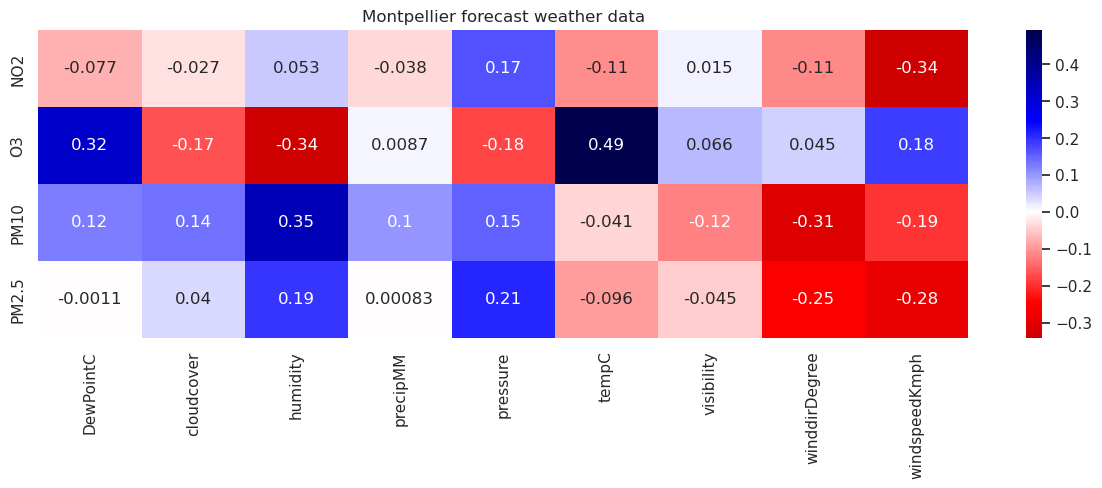

In [11]:
masked_heatmap(corr_data_forecast_montpellier, title = 'Montpellier forecast weather data')

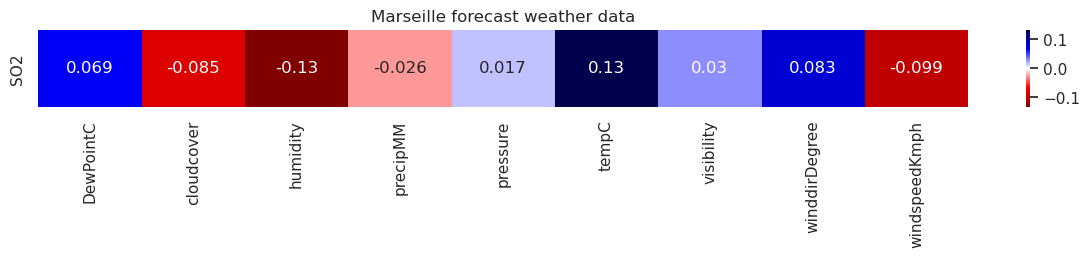

In [12]:
masked_heatmap(corr_data_forecast_marseille, title = 'Marseille forecast weather data', figsize = (15, 1))

It seems clear we can drop `precipMM` and `visibility` for all pollutants for the forecast data.

In [13]:
weather_forecast_data.drop(columns = ['precipMM', 'visibility'], inplace = True)

# Correlations between historical weather and pollutant concentrations

In [14]:
corr_data_actual_montpellier = (
    pd.concat(
        [pollutants_df.drop(columns = 'SO2'), actual_weather_data.loc['Montpellier']],
        axis = 1
    )
    .corr()
    .iloc[:4, 4:]
)

corr_data_actual_marseille = (
        pd.concat(
        [pollutants_df['SO2'], actual_weather_data.loc['Marseille']],
        axis = 1
    )
    .corr()
    .iloc[:1, 1:]
)

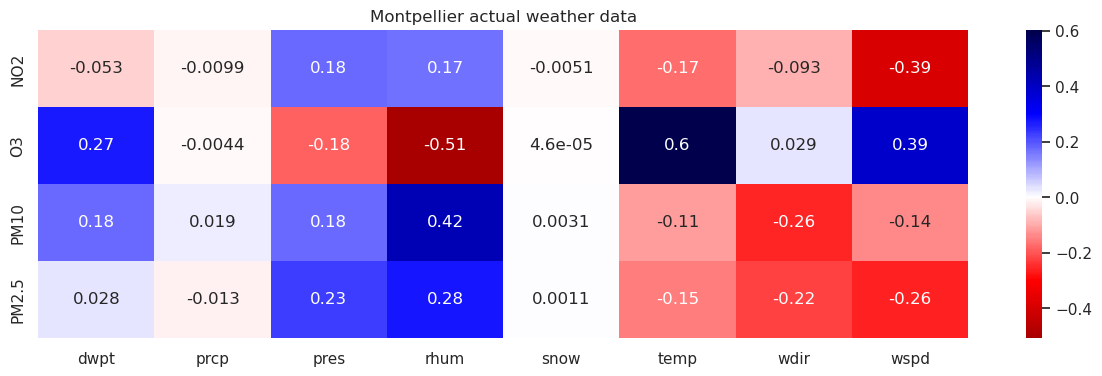

In [15]:
masked_heatmap(corr_data_actual_montpellier, title = 'Montpellier actual weather data')

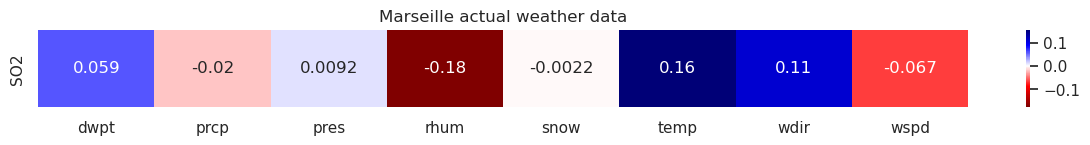

In [16]:
masked_heatmap(corr_data_actual_marseille, title = 'Marseille actual weather data', figsize = (15, 1))

We can safely drop `snow` and `prcp` for all pollutants for the actuals weather data.

It also seems likely that SO2 concentrations are hardly affected by weather at all given the very low correlations for both actuals and forecast.

In [17]:
actual_weather_data.drop(columns = ['snow', 'prcp'], inplace = True)

In [18]:
weather_forecast_data

DewPointC  cloudcover  humidity  pressure  \
location    Datetime                                                         
Marseille   2013-01-02 00:00:00          5          18        85      1017   
            2013-01-02 01:00:00          5          22        86      1017   
            2013-01-02 02:00:00          5          26        86      1017   
            2013-01-02 03:00:00          5          30        87      1017   
            2013-01-02 04:00:00          4          24        86      1017   
...                                    ...         ...       ...       ...   
Montpellier 2022-08-29 19:00:00         22           6        76      1014   
            2022-08-29 20:00:00         21           8        79      1014   
            2022-08-29 21:00:00         21           9        82      1014   
            2022-08-29 22:00:00         21           8        82      1014   
            2022-08-29 23:00:00         20           8        83      1014   

                                 tempC  winddirDegree  windspeedKmph  
location    Datetime                                                  
Marseille   2013-01-02 00:00:00      8            314             20  
            2013-01-02 01:00:00      7            317             23  
            2013-01-02 02:00:00      7            320             27  
            2013-01-02 03:00:00      7            323             30  
            2013-01-02 04:00:00      6            322             28  
...                                ...            ...            ...  
Montpellier 2022-08-29 19:00:00     26            117             16  
            2022-08-29 20:00:00     25            110             14  
            2022-08-29 21:00:00     24            103             12  
            2022-08-29 22:00:00     24             97             13  
            2022-08-29 23:00:00     23             90             14  

[169296 rows x 7 columns]

In [19]:
actual_weather_data

dwpt    pres  rhum  temp   wdir  wspd
location    Datetime                                                  
Marseille   2013-01-02 00:00:00   3.8  1016.8  96.0   4.4  100.0   1.8
            2013-01-02 01:00:00   3.4  1016.9  96.0   4.0  180.0   3.6
            2013-01-02 02:00:00   5.7  1016.9  91.0   7.1  310.0  18.4
            2013-01-02 03:00:00   4.5  1016.9  81.0   7.6  320.0  20.5
            2013-01-02 04:00:00   3.5  1017.0  75.0   7.7  310.0  22.3
...                               ...     ...   ...   ...    ...   ...
Montpellier 2022-08-29 19:00:00  24.0  1016.0  94.0  25.0  130.0  19.0
            2022-08-29 20:00:00  23.1  1016.0  89.0  25.0  140.0  15.0
            2022-08-29 21:00:00  23.3  1017.4  89.0  25.2  170.0  11.0
            2022-08-29 22:00:00  19.9  1015.0  78.0  24.0   10.0  28.0
            2022-08-29 23:00:00  22.1  1015.0  89.0  24.0  100.0  13.0

[169296 rows x 6 columns]

# Save final data

In [20]:
wf_path = 'data/Weather forecast/Historical to 2022-08-29/Processed weather forecast data.gz'
weather_forecast_data.to_csv(wf_path)

In [21]:
actual_path = 'data/Historical weather/Historical to 2022-08-29/Processed historical weather data.gz'
actual_weather_data.to_csv(actual_path)

In [22]:
wf_pickle_path = 'data/Weather forecast/Historical to 2022-08-29/Processed weather forecast data.pkl'
with open(wf_pickle_path, 'wb') as file:
    pickle.dump(weather_forecast_data.reset_index(), file)

In [23]:
actual_pickle_path = 'data/Historical weather/Historical to 2022-08-29/Processed historical weather data.pkl'
with open(actual_pickle_path, 'wb') as file:
    pickle.dump(actual_weather_data.reset_index(), file)